In [183]:
# LendingClub Data Statistical Analysis
# Two sources of data and a data dictionary
# Data in CSV and SQL files are provided - Kaggle
# Looks like FICO score data is missing and some column names are different
import math
import sqlite3
import csv
import pandas as pd
import collections
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dateutil.parser import parse
from datetime import datetime
from statsmodels.stats import weightstats as stests
from scipy.stats import ks_2samp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

dataURL = 'https://www.kaggle.com/wendykan/lending-club-loan-data/downloads/lending-club-loan-data.zip'
homeDir = "/fdata/LendingClub/lending-club-loan-data/"
fnSQL = "database.sqlite"
fnCSV = "loan.csv"

# list of sub grade categories
sg = ['A1','A2','A3','A4','A5',\
      'B1','B2','B3','B4','B5',\
      'C1','C2','C3','C4','C5',\
      'D1','D2','D3','D4','D5',\
      'E1','E3','E3','E4','E5',\
      'F1','F2','F3','F4','F5',\
      'G1','G2','G3','G4','G5']

# read in column names from loan.csv
with open(homeDir+fnCSV) as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    cnCSV = next(reader)[0].split(',')
#print(len(cnCSV))
#print(cnCSV)
# 74 Data Columns

# get column of data from CSV file
def getCSVColumn(header):
    try:
        indx = cnCSV.index(header)
        with open(homeDir+fnCSV) as csvfile:
            reader = csv.reader(csvfile)
            tcol = list(zip(*reader))[indx]
            col = list(tcol)
            col.pop(0)
            return col
    except ValueError:
        print("Column not found:", header)
        col = []
        return col

# get column of data from SQLite file
def getSQLiteColumn(header):
    col = []
    conn = sqlite3.connect(homeDir+fnSQL)
    cursor = conn.execute('SELECT ' + header + ' FROM loan')
    for row in cursor.fetchall():
        col.append(row[0])
    return col

# statistical KS comparison of factor across sub grades
# test distributions are the same of factor in columns 10 sub-grade (2 grades) apart
def slidingKSTest(subgrade, factor, space):
    p = np.zeros(shape=(35 - space))
    for i in range(35 - space):
        s1 = sg[i]
        s2 = sg[i+space]
        t1 = []
        t2 = []
        for indx, entry in enumerate(subgrade):
            if entry == s1:
                if not math.isnan(factor[indx]):
                    t1.append(factor[indx])
            if entry == s2:
                if not math.isnan(factor[indx]):
                    t2.append(factor[indx])
        #print(len(t1),len(t2))
        a, b = ks_2samp(t1,t2)
        p[i] = b
    return p

# Statistical KS comparison between A grade and factor from all other sub-grades
# test 'distributions are the same'
def slidingAGrade_KSTest(subgrade, factor):
    p = np.zeros(shape=(30))
    for i in range(30):
        s1 = 'A'
        s2 = sg[i+5]
        t1 = []
        t2 = []
        for indx, entry in enumerate(subgrade):
            if entry[0:1] == s1:
                if not math.isnan(factor[indx]):
                    t1.append(factor[indx])
            if entry == s2:
                if not math.isnan(factor[indx]):
                    t2.append(factor[indx])
        #print(len(t1),len(t2))
        a, b = ks_2samp(t1,t2)
        p[i] = b
    return p


In [165]:
# Load in processed LoanClubData
processed = pd.read_pickle(homeDir+'processed.pkl')
# do final clean up of data
#Add loan status column
lstat = getCSVColumn('loan_status')
lstat_s = pd.Series(lstat)
processed['Loan Status'] = lstat_s
processed.sort_values('Sub Grade',inplace=True)
processed['Debt Income Ratio'] =  processed['Debt Income Ratio'].apply(pd.to_numeric, errors='coerce')
processed['Debt Income Ratio - Joint'] =  processed['Debt Income Ratio - Joint'].apply(pd.to_numeric, errors='coerce')
processed['Annual Income'] =  processed['Annual Income'].apply(pd.to_numeric, errors='coerce')
processed['Annual Income - Joint'] =  processed['Annual Income - Joint'].apply(pd.to_numeric, errors='coerce')
processed['All Credit Ratio'] =  processed['All Credit Ratio'].apply(pd.to_numeric, errors='coerce')
processed['Current Deliquent Accounts'] =  processed['Current Deliquent Accounts'].apply(pd.to_numeric, errors='coerce')
processed['Collections (12mths)'] =  processed['Collections (12mths)'].apply(pd.to_numeric, errors='coerce')
processed['Delquient (2yrs)'] =  processed['Delquient (2yrs)'].apply(pd.to_numeric, errors='coerce')
processed['Personal Finance Inq'] =  processed['Personal Finance Inq'].apply(pd.to_numeric, errors='coerce')
processed['Credt Inq 12mts'] =  processed['Credt Inq 12mts'].apply(pd.to_numeric, errors='coerce')
processed['Revolving Credit Balance'] =  processed['Revolving Credit Balance'].apply(pd.to_numeric, errors='coerce')
processed['Revolving Credit Ratio'] =  processed['Revolving Credit Ratio'].apply(pd.to_numeric, errors='coerce')
print(processed.count())

Sub Grade                      887379
Loan Amount                    887379
Interest Rage                  887379
Annual Income                  887375
Annual Income - Joint             511
Income Verification            887379
Income Verification - Joint    887379
Data Issued                    887379
Debt Income Ratio              887379
Debt Income Ratio - Joint         509
Revolving Credit Balance       887379
Revolving Credit Ratio         886877
All Credit Ratio                21372
Current Deliquent Accounts     887379
Collections (12mths)           887379
Delquient (2yrs)               887379
Years Employed                 887379
Home Ownership                 887379
Inquiries (6mths)              887379
Personal Finance Inq           887379
Credt Inq 12mts                 17389
Inst Credit Ratio              887379
Earliest Credit                887379
Max Bal Revol                   21372
Total Coll E Owed              817103
Mths Last Delq                 433067
Mths Last De

In [166]:
# save final data
processed.to_pickle(homeDir+'processed_final.pkl')

/usr/lib/python3/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


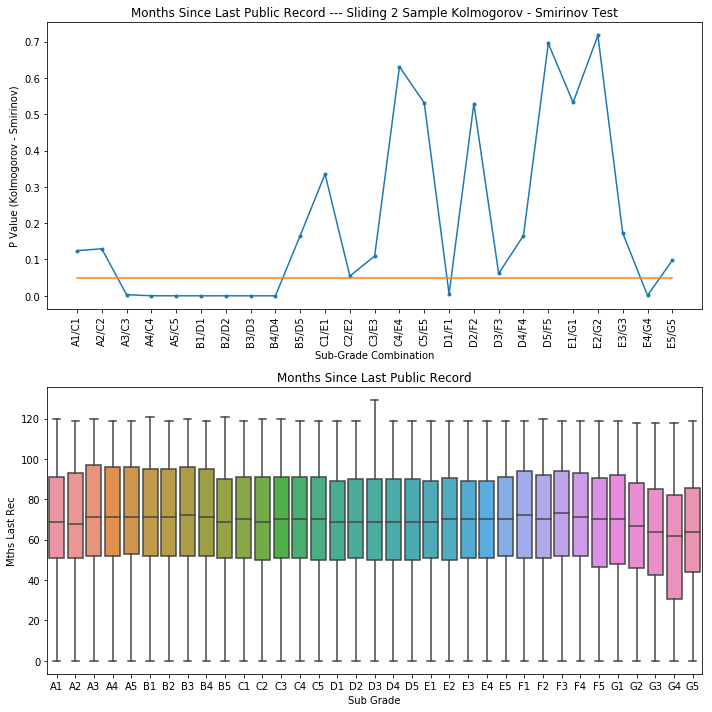

In [198]:
col = 'Mths Last Rec'
nam = 'Months Since Last Public Record'
labels = ['A1/C1','A2/C2','A3/C3','A4/C4','A5/C5',\
          'B1/D1','B2/D2','B3/D3','B4/D4','B5/D5',\
          'C1/E1','C2/E2','C3/E3','C4/E4','C5/E5',\
          'D1/F1','D2/F2','D3/F3','D4/F4','D5/F5',\
          'E1/G1','E2/G2','E3/G3','E4/G4','E5/G5']
labels_5 = ['A1/B1','A2/B2','A3/B3','A4/B4','A5/B5',\
            'B1/C1','B2/C2','B3/C3','B4/D4','B5/C5',\
            'C1/D1','C2/D2','C3/D3','C4/D4','C5/D5',\
            'D1/E1','D2/E2','D3/E3','D4/E4','D5/E5',\
            'E1/F1','E2/F2','E3/F3','E4/F4','E5/F5',\
            'F1/G1','F2/G2','F3/G3','F4/G4','F5/G5']

sgrade = list(processed['Sub Grade'])
fac = list(processed[col])
p1 = slidingKSTest(sgrade, fac, 10)
#print(p1)

fig, (ax1 , ax2) = plt.subplots(2,1)
fig.set_size_inches(10, 10)
#fig.tight_layout()
plt.subplots_adjust(hspace=0.25)
ax1.plot(p1,marker='.')
ax1.plot([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,\
          0.05,0.05,0.05,0.05,0.05,0.05,0.05])
ax1.margins(0.05)
ax1.set_xticks(np.arange(0, 25, 1.0))
ax1.set_xticklabels(labels,rotation=90)
ax1.set_xlabel('Sub-Grade Combination')
ax1.set_ylabel('P Value (Kolmogorov - Smirinov)')
ax1.set_title(nam+' --- Sliding 2 Sample Kolmogorov - Smirinov Test')
sns.boxplot(x='Sub Grade',y=col,data=processed)
ax2.set_title(nam)
#ax2.set_ylim([0,300000])
plt.show()
fig.savefig(homeDir+'images/'+nam.replace(' ','')+'.png')